## Example: CLD on Sleep and Depressive symptoms
In our first example, we will implement a system dynamics model (SDM) analysis of a causal loop diagram (CLD) published as an example in the Education Corner article by Uleman et al (2024) doi: ...
This CLD focuses on the feedback loops between sleep and depressive symptoms in young adults.

In Kumu, the diagram looks as follows:

<img src="./Kumu/archetype_goal_seeking CLD.png" alt="drawing" width="800"/>

To analyze this CLD, we will first run several initialization steps and import the Kumu file (which can be exported from the live Kumu page). Two adjustments are needed to this Kumu file. Firstly, in the 'Elements' sheet, the 'Type' column should specify for each variable whether they are an auxiliary, stock, or constant (see the manuscript for suggestions on how to select between these different variable types). Secondly, if Interaction terms have been identified in the system, these can be incorporated by adding a sheet called 'Interactions' (see our example).

Our method requires the user to specify several options, which are stored in a settings dataframe (s) in the settings folder within Examples. These mandatory options are the time unit (months in this case), the end time (12 months), the time-step of interest (one month), and the variable of interest (state of the world). The settings can be adjusted in the relevant json file in the Settings folder.

There are also several default settings that can be adjusted, namely the number of samples that should be drawn from the uncertain model parameters (N; 1000 by default) and the maximum parameter value for the regular parameters (0.2 by default) and the interaction term parameters (0.1 by default). These parameters should be tuned a bit, depending on the number of timesteps. If too high, the model may reach impossible values (e.g., infinity). The user can also decide whether or not to save the plots generated by this file and whether interventions should be run (both are True (1) by default).

When interaction terms are specified in the Kumu file, the user can set the setting 'interaction_terms' to 1 (True). If not, the interaction terms parameter will automatically set to False and the CLD will be interpreted as a linear system of equations. For linear systems, the user can decide whether to solve the equations analytically or numerically through the 'solve_analytically' setting (True by default for linear SDMs). The benefit of the algebraic solution is that it is more accurate (and faster?).

In [28]:
# Initialize the settings and load relevant packages and modules
setting_name = 'archetype_goal_seeking'
%run ../initialize.py {setting_name} {None} 

Test for loading KUMU table passed.
Test comparison with vectorized implementation passed.
Test comparison analytic and numerical solution for linear model passed.


In [17]:
## Print the settings
s

namespace(seed=999,
          N=100,
          t_end=12,
          dt=1,
          time_unit='Months',
          variable_of_interest='state_of_the_world',
          max_parameter_value=0.2,
          max_parameter_value_int=0.1,
          solve_analytically=1,
          interaction_terms=0,
          save_results=0,
          setting_name='archetype_goal_seeking',
          stocks=['state_of_the_world'],
          auxiliaries=['distance_from_goal'],
          constants=['goal'],
          variables=['distance_from_goal', 'state_of_the_world', 'goal'],
          stocks_and_constants=['state_of_the_world', 'goal'],
          stocks_and_auxiliaries=['distance_from_goal', 'state_of_the_world'],
          var_to_type={'distance_from_goal': 'auxiliary',
                       'state_of_the_world': 'stock',
                       'goal': 'constant'},
          simulate_interventions=True,
          t_eval=array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
          sol

One the settings have been set, we can run simulations from the SDM-converted CLD.

In [29]:
### Run simulations
df_sol_per_sample = []  # List for storing the solution dataframes
df_sol_per_sample_no_int = []   # List for storuing the solution dataframes without interventions
param_samples = {var : {} for var in s.intervention_variables}  # Dictionary for storing the parameters across samples

for num in tqdm(range(s.N)):  # Iterate over the number of samples
    df_sol = []
    for i, var in enumerate(s.intervention_variables):
        # Set the initial condition for the stocks to zero
        x0 = np.zeros(len(s.stocks_and_constants), order='F')  # By default no intervention on a stock or constant
        intervention_auxiliaries = []  # By default no intervention on an auxiliary

        if var in s.stocks_and_constants:
            x0[s.stocks_and_constants.index(var)] += 1  # Increase the (baseline) value of the stock/constant by 1
        else:
            intervention_auxiliaries = [var]  # Select the auxiliary to get an intercept of 1 in sample_model_parameters function

        params = sdm.sample_model_parameters(intervention_auxiliaries)  # Sample model parameters
        new_params = sdm.make_equations_auxiliary_independent()  # Remove auxiliaries from the equations
        A, K, b = sdm.get_A_and_K_matrices()  # Get A and K matrices and intercept vector from the parameter dictionary without auxiliaries
        df_sol_per_intervention = sdm.run_SDM(x0, A, K, b)
        df_sol += [df_sol_per_intervention]

        # Store the model parameters
        if num == 0: 
            param_samples[var] = {target : {source : [params[target][source]] for source in params[target]} for target in params}
        else:
            for target in params:
                for source in params[target]:
                    param_samples[var][target][source] += [params[target][source]]

        if i == 0:  # Run once with no interventions
            s.simulate_interventions = False
            x0 = np.ones(len(s.stocks_and_constants), order='F') * 0.1 # Set all initial conditions to a small value
            intervention_auxiliaries = []  # No interventions, so no auxiliary interventions
            params = sdm.sample_model_parameters(intervention_auxiliaries)  # Sample model parameters
            new_params = sdm.make_equations_auxiliary_independent()  # Remove auxiliaries from the equations
            A, K, b = sdm.get_A_and_K_matrices()  # Get A and K matrices and intercept vector from the parameter dictionary without auxiliaries
            df_sol_no_int = [sdm.run_SDM(x0, A, K, b)]

            df_sol_per_sample_no_int += df_sol_no_int
            # TODO: Store params for simulations without interventions?

    df_sol_per_sample += [df_sol]


100%|██████████| 100/100 [00:06<00:00, 16.50it/s]


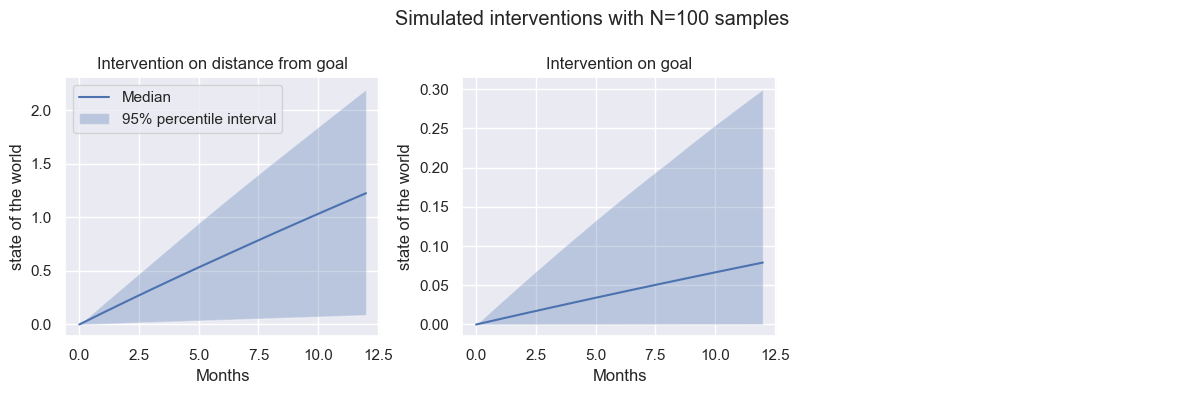

<Figure size 640x480 with 0 Axes>

In [30]:
## Plot settings
s.interval_type = "percentile" # "confidence", "percentile", "spaghetti"
s.confidence_bounds = .95

# ## Without intervention:
# plot_simulated_data(df_sol_per_sample_no_int, "Simulation data with N="+ str(s.N) + " samples", s)


plot_simulated_interventions(df_sol_per_sample, "Simulated interventions with N="+ str(s.N) + " samples", s)

if s.save_results:
    title = 'simulated_interventions_plots_per_individual_N' + str(s.N) + '.jpg'
    plt.savefig(os.path.join("Results", curr_time + '_' + setting_name, 
            title),
            format='jpg', dpi=300
           )       

Intervention effect on var of interest state_of_the_world by:
- distance_from_goal : 1.23 +- SD: 0.63
- goal : 0.11 +- SD: 0.09


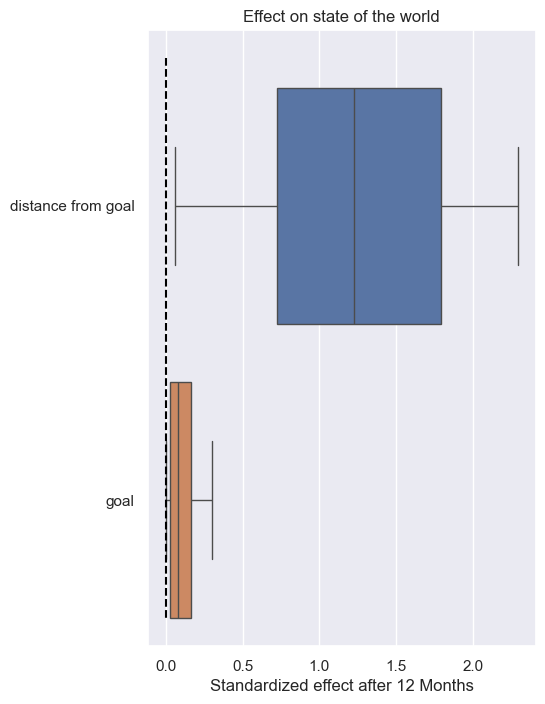

In [31]:
intervention_effects = sdm.get_intervention_effects(df_sol_per_sample)
plot_simulated_intervention_ranking(intervention_effects, s)

In [32]:
# Comparisons between interventions
interactive_plot = plot_simulated_interventions_compare(df_sol_per_sample, s)
display(interactive_plot)

TraitError: Invalid selection: value not found

## Feedback loop analysis with Loops That Matter

In [7]:
### Combine the time values for the loop scores, either as the mean or the last value
combine_loop_type = 'mean'  #'final'  
cut_off_importance = 0.01  # 0.005  # Select most important

#for j, int_var in enumerate(s.intervention_variables):
int_var = "Proinflammatory_processes"  # Select an intervention for which we will assess the feedback loop dominance
j = s.intervention_variables.index(int_var)

## Get the right loop scores for specific intervention
linkscores_per_sample = []
loopscores_per_sample = []
loopscores_combined_per_sample = []
for k in range(s.N):
    df_i = df_sol_per_sample[k][j]
    params = {target : {source : param_samples[int_var][target][source][k] for source in param_samples[int_var][target]} for target in param_samples[int_var]}
    linkscores = sdm.get_link_scores(df_i, params)
    loopscores, feedback_loops = sdm.get_loop_scores(linkscores)
    linkscores_per_sample += [linkscores]
    loopscores_per_sample += [loopscores]

    if combine_loop_type == "mean":
        loopscores_combined_over_time = {loop : np.mean(loopscores[loop]) for loop in loopscores}
    elif combine_loop_type == "final":
        loopscores_combined_over_time = {loop : loopscores[loop][-1] for loop in loopscores}
    else:
        raise ValueError("combine_loop_type must be either 'mean' or 'final'.") 
    
    loopscores_combined_per_sample += [loopscores_combined_over_time]

loopscores_combined_per_sample = {loop : [loopscores_combined_per_sample[k][loop] for k in range(s.N)] for loop in loopscores_combined_per_sample[0]}

# Plot average or final loop importance over the time span
fig = plt.figure(figsize=(5, 8))
ax = fig.add_subplot(111)
df_loops = pd.DataFrame(loopscores_combined_per_sample)

df_loops = df_loops.loc[:, df_loops.mean().abs() > cut_off_importance]  # Plot only the most relevant loops
df_loops = df_loops.reindex(columns=list(
                    df_loops.median().sort_values(ascending=False).index))
sns.boxplot(data=df_loops, showfliers=False, whis=True, orient='h')
plt.vlines(x=0, ymin=-0.5, ymax=len(df_loops.columns) - 0.6, colors='black', linestyles='dashed')
plt.xlabel("Contribution to dynamics (" + combine_loop_type + " over time)")
plt.title("Top feedback loops for intervention on " + " ".join(int_var.split("_")))


ValueError: 'Proinflammatory_processes' is not in list

In [8]:
num_loops = len(df_loops.columns)
num_rows = int(np.ceil(num_loops/2))
fig, axs = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
fig.suptitle("Top contributing feedback loops for intervention on " + " ".join(int_var.split("_")))
color_map = plt.colormaps["Paired"]

ax = axs.flatten()
for i, loop in enumerate(df_loops.columns):
    for k in range(s.N):
        df_loops_t = pd.DataFrame(loopscores_per_sample[k])
        df_loops_t = df_loops_t[df_loops.columns]
        ax[i].plot(df_loops_t[loop], alpha=.3, color=color_map(i))      

    ax[i].set_ylabel("Contribution to dynamics")
    ax[i].set_title(loop)

    if i > num_loops - 3: 
        ax[i].set_xlabel(s.time_unit)


NameError: name 'df_loops' is not defined

In [9]:
confidence_bounds = .50

fig, axs = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
ax = axs.flatten()
fig.suptitle("Top contributing feedback loops for intervention on " + " ".join(int_var.split("_")))
color_map = plt.colormaps["Paired"]
 #plt.cm.get_cmap('Paired', num_loops) #

for j, loop in enumerate(df_loops.columns):
    avg_at_time_t = []
    lb_confs_at_time_t = []
    ub_confs_at_time_t = []

    for i, t in enumerate(s.t_eval[1:]):
        samples_at_time_t = [loopscores_per_sample[n][loop][i] for n in range(s.N)]

        avg_at_time_t.append(np.median(samples_at_time_t))
        lower_percentile = (1 - confidence_bounds) / 2 * 100
        upper_percentile = (1 + confidence_bounds) / 2 * 100
        lb_confs_at_time_t.append(np.percentile(samples_at_time_t, lower_percentile))
        ub_confs_at_time_t.append(np.percentile(samples_at_time_t, upper_percentile))
            
    ax[j].plot(s.t_eval[1:], avg_at_time_t, label=" ".join(var.split("_")), color=color_map(j)) 
    ax[j].fill_between(s.t_eval[1:], lb_confs_at_time_t, ub_confs_at_time_t, alpha=.3, color=color_map(j))    
    ax[j].set_ylabel("Contribution to dynamics")
    ax[j].set_title(loop)
    if j > num_loops - 3: 
        ax[j].set_xlabel(s.time_unit)


NameError: name 'num_rows' is not defined

## Sensitivity analysis
Assessing which model parameter is the most sensitive over all samples, including the interventions

In [13]:
## Estimate spearman correlation for all model parameters (sensitivity analysis)
def flatten(xss):
    return [x for xs in xss for x in xs]

#param_names = flatten([[int_var+"//"+source+"->"+target for source in param_samples[int_var][target]] for target in param_samples[int_var]])
param_names = flatten([[source+"->"+target for source in param_samples[int_var][target]] for target in param_samples[int_var]])

df_SA = pd.DataFrame(columns=param_names+["Effect"])

for i, int_var in enumerate(s.intervention_variables):
    for n in range(s.N):
        #params_curr = flatten(flatten([[[param_samples[int_var][target][source][n] for source in param_samples[int_var][target]] for target in param_samples[int_var]]] for int_var in s.intervention_variables))
        params_curr = flatten([[param_samples[int_var][target][source][n] for source in param_samples[int_var][target]] for target in param_samples[int_var]])
        eff_size = abs(df_sol_per_sample[n][i].loc[df_sol_per_sample[n][i].Time==s.t_eval[-1], s.variable_of_interest])  # Absolute effect size
        new_row = np.array(params_curr + [float(eff_size.iloc[0])])
        df_SA_new = pd.DataFrame(new_row, index=param_names+["Effect"]).T
        df_SA = pd.concat([df_SA, df_SA_new], ignore_index=True)

## Top ranked model parameters across the interventions (with respect to the effect on depressive symptoms)
df_SA.corr('spearman').abs()['Effect'][[p for p in param_names if "Intercept" not in p]].sort_values(ascending=False)


C:\Users\vvvas\AppData\Local\Temp\ipykernel_21024\2486763872.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_SA = pd.concat([df_SA, df_SA_new], ignore_index=True)


Perceived_stress->Depressive_symptoms             0.326088
Proinflammatory_processes->Depressive_symptoms    0.203837
Depressive_symptoms->Perceived_stress             0.099657
Sleep_problems->Depressive_symptoms               0.084582
Treatment->Depressive_symptoms                    0.071163
Physical_activity->Proinflammatory_processes      0.069412
Body_fat->Proinflammatory_processes               0.066376
Childhood_adversity->Depressive_symptoms          0.064141
Childhood_adversity->Perceived_stress             0.063283
Physical_activity->Body_fat                       0.062994
Proinflammatory_processes->Sleep_problems         0.060894
Depressive_symptoms->Proinflammatory_processes    0.059088
Body_fat->Sleep_problems                          0.058374
Perceived_stress->Sleep_problems                  0.057850
Depressive_symptoms->Treatment                    0.052858
Sleep_problems->Body_fat                          0.040401
Depressive_symptoms->Physical_activity            0.0390

## Stability analysis
TODO

In [ ]:
### Stability analysis
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint

def stability_analysis(A, b=[0]):
    # If b is provided, transform the system
    if np.all(b==0):  # The system is homogenous
        equilibrium = np.zeros(np.size(b))
    else:  # The system is not homogenous
        equilibrium = -np.matmul(np.linalg.inv(A), b)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # Check stability
    stability = all(np.real(eigenvalue) < 0 for eigenvalue in eigenvalues)

    return stability, equilibrium, eigenvalues, eigenvectors

# Define A and b
A = np.array([[1, 2], [3, 4]])
b = np.array([0, 0]) # np.array([5, 6])

# Perform stability analysis
stability, equilibrium, eigenvalues, eigenvectors = stability_analysis(A, b)

print(f"The system is stability: {stability}")
print(f"At equilibrium point:  {equilibrium}")
print(f"Eigenvalues: {eigenvalues}")
print(f"Eigenvectors: {eigenvectors}")

# Define the system of ODEs
def system(x, t, A, K, b):
    return np.matmul(A, x) + np.matmul(Kx, x) + b

# Define the Jacobian of the system
##def jacobian(x, A, K):
    return A + 2 * K.dot(np.outer(x, np.eye(len(x))))

b = np.ones([3])
# Find the equilibrium point

# TODO: Sample from range [-100, 100] maybe Latin hypercube to check all initial values to find equilibria for nonlinear SDM
# x_star = fsolve(lambda x: system(x, 0, A, K, b), np.zeros([3]))

# # Compute the Jacobian at the equilibrium point
# J = A + 2 * np.matmul(K, x_star)
# print("Jacobian matrix at the equilibrium point is:")

# stability, notrelevant, eigenvalues, eigenvectors = stability_analysis(J, b)

# print(f"The system is stability: {stability}")
# print(f"At equilibrium point:  {x_star}")
# print(f"Eigenvalues: {eigenvalues}")
# print(f"Eigenvectors: {eigenvectors}")

